In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
import random

from tqdm import tqdm

from xgboost import XGBRegressor, XGBRanker
#from sklearn.xgboost import XGBRegressor

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, HistGradientBoostingClassifier, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, ndcg_score, make_scorer
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

import lightgbm

In [2]:
# data = pd.read_csv('data/train_train.csv')

train_data = pd.read_csv('data/train_combined_FE.csv')

train_data.drop('Unnamed: 0', axis=1, inplace=True)
train_data.drop('date_time', axis = 1, inplace=True)

#train_data.drop('prob_searchclick', axis = 1, inplace=True)

train_data['target'] = train_data['click_bool'] + 4* train_data['booking_bool']
train_data['target'].loc[train_data['target'].isna()] = int(0)
train_data.sort_values(['srch_id', 'target'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_29125/3423285425.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['target'].loc[train_data['target'].isna()] = int(0)


In [3]:
test_data = pd.read_csv('data/train_test_FE.csv')

test_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop('date_time', axis = 1, inplace=True)

test_data['target'] = test_data['click_bool'] + 4* test_data['booking_bool']
test_data['target'].loc[test_data['target'].isna()] = int(0)
test_data.sort_values(['srch_id', 'target'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_29125/3495546490.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['target'].loc[test_data['target'].isna()] = int(0)


In [4]:
X_bal = train_data.drop(['click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1)
y_bal = train_data['target']

groups = X_bal.groupby('srch_id').size().to_frame('size')['size'].to_numpy()
groups_val = test_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [5]:
# LambdaMART

baseline = lightgbm.LGBMRanker(
        objective="lambdarank",
        metric="ndcg",
        n_estimators=2000,
        learning_rate=0.05,
        random_state=40,
        seed=42,
        boosting_type="gbdt",
        # eval_metric = 'ndcg@5'
    )

In [6]:
def ndcg_scorer(rel, pred, groups):
    mean_ndcg = 0
    unique_ids = np.unique(groups)
    
    for id in random.sample(list(unique_ids), 5000):

        r = rel[groups == id]
        p = pred[groups == id]


        if len(r) > 1:
            ndcg = ndcg_score([r], [p], k = 5)

    mean_ndcg = mean_ndcg/len(unique_ids)

    return mean_ndcg

In [7]:
# rfe = RFE(estimator=baseline, n_features_to_select=45)
# pipeline = Pipeline(steps=[('s',rfe),('m',baseline)], verbose=True)

# cv = GroupKFold(n_splits=3)
# n_scores = cross_val_score(pipeline, X_bal.drop('srch_id', axis = 1), y_bal, groups = X_bal['srch_id'].to_numpy(), scoring = ndcg_scorer, cv=cv, n_jobs=-1, error_score='raise')

# pipeline.fit(X_bal.drop('srch_id', axis = 1), y_bal, group= X_bal['srch_id'].to_numpy())

# # get reduced feature set
# features = pipeline[:-1].get_feature_names_out()

# # y_pred_reduced = pipeline.predict(X_test)
# # y_train_pred_reduced = pipeline.predict(X_train)

In [8]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [9]:
baseline.fit(X_bal.drop(['srch_id'], axis = 1),y_bal, group = groups)
            #  , eval_set= [(test_data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
            #                           , axis=1), test_data['target'])], eval_group = [groups_val])


[LightGBM] [Warning] seed is set=42, random_state=40 will be ignored. Current value: seed=42


LGBMRanker(learning_rate=0.05, metric='ndcg', n_estimators=2000,
           objective='lambdarank', random_state=40, seed=42)

In [10]:
# hyper param tuning
# param_dist = {'min_samples_split' : [2, 10_000], 'max_depth' : [3, 15]}
# hp_search = HalvingRandomSearchCV(baseline, param_dist, min_resources=50_000).fit(X_train, y_train)

In [11]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
# hp_search.best_params_

In [ ]:
# groups = X_bal.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

# baseline.fit(X_bal.drop(['srch_id'], axis = 1),y_bal, group = groups)


KeyboardInterrupt



In [12]:
test_data['pred_score'] = baseline.predict(test_data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1))


In [13]:
print('MSE', mean_squared_error(test_data['target'], test_data['pred_score']))

MSE 6.225385058825902


In [14]:
test_data['pred_rank'] = test_data.groupby('srch_id')['pred_score'].rank(ascending=False).astype(int)
test_ids = test_data["srch_id"].unique()

In [15]:
# scoring with ndcg
mean_ndcg = 0
counter = 0

# sampled_ids = random.sample(list(test_ids), 5000)

for id in tqdm(test_ids):
    if len(test_data['target'].loc[test_data['srch_id'] == id]) > 1:
        ndcg = ndcg_score([test_data['target'].loc[test_data['srch_id'] == id].astype(int).to_numpy()],
                        [test_data['pred_score'].loc[test_data['srch_id'] == id].to_numpy()], k = 5)

    mean_ndcg += ndcg
    if ndcg < 1.0:
        counter +=1

mean_ndcg = mean_ndcg/len(test_ids)

100%|██████████| 59939/59939 [01:37<00:00, 614.02it/s]


In [16]:
mean_ndcg

0.34909105727745615

In [ ]:
len(test_data)

496854

AttributeError: 'LGBMRanker' object has no attribute 'features'

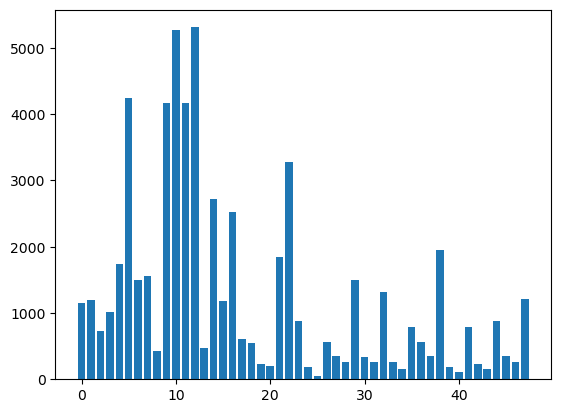

In [ ]:
plt.bar(range(len(baseline.feature_importances_)), baseline.feature_importances_)
plt.figsize= (4,20)
# plt.xlabel(baseline.get_booster().feature_names, rotation = 90)
plt.xticks(range(len(baseline.feature_importances_)), baseline.features,rotation = 90)
plt.tight_layout()
plt.show()

## Predict the test dataset and bring it into requested format

In [ ]:
# comp_data = pd.read_csv('data/test_set.csv')
# comp_data.drop('Unnamed: 0', axis=1, inplace=True)

comp_data = pd.read_csv('data/test_set_VU_DM.csv')
comp_data.drop('date_time', axis = 1, inplace=True)

In [ ]:
comp_data.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,24,216,NaN,NaN,219,3180,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,24,216,NaN,NaN,219,5543,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,24,216,NaN,NaN,219,14142,2,3.5,1,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,24,216,NaN,NaN,219,22393,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,24,216,NaN,NaN,219,24194,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# comp_data['prediction'] = baseline.predict(comp_data.drop(['srch_id', 'in_train'], axis=1))

comp_data['prediction'] = baseline.predict(comp_data.drop(['srch_id'], axis=1))

In [ ]:
# sort values for final format
comp_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [ ]:
filename = 'data/predictions/prediction'+str(datetime.now())+'.csv'
comp_data[['srch_id', 'prop_id']].to_csv(filename, index=False)